In [88]:
import os
import glob

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import imageio

from pathlib import Path
from operator import itemgetter 

In [2]:
tf.config.gpu.set_per_process_memory_growth(True)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


## Load csv data

In [3]:
rel_df = pd.read_csv('dataset/train_relationships.csv')
rel_df.head()

,p1,p2
0,F0002/MID1,F0002/MID3
1,F0002/MID2,F0002/MID3
2,F0005/MID1,F0005/MID2
3,F0005/MID3,F0005/MID2
4,F0009/MID1,F0009/MID4


In [4]:
rel_df.p1.value_counts()[:10]

F0825/MID5    9
F0825/MID6    9
F0552/MID1    9
F0390/MID2    8
F0390/MID9    8
F0690/MID5    7
F0818/MID1    7
F0165/MID1    7
F0425/MID5    7
F0690/MID6    7
Name: p1, dtype: int64

## Show images

Helpers functions

In [5]:
def get_images_names(path):
    return list(map(lambda x: os.path.join(path, x.name), os.scandir(path)))

def plot_faces(index, limit=10):
    path = Path('dataset/train')
    p1_imgs = get_images_names(path / rel_df.loc[index, 'p1'])
    p2_imgs = get_images_names(path / rel_df.loc[index, 'p2'])
    images = list(zip(p1_imgs, p2_imgs))[:limit]
    fig, axes = plt.subplots(nrows=2, ncols=len(images), figsize=(20, 4))
    
    for i, (img1, img2) in enumerate(images):
        axes[0][i].imshow(imageio.imread(img1))
        axes[1][i].imshow(imageio.imread(img2))

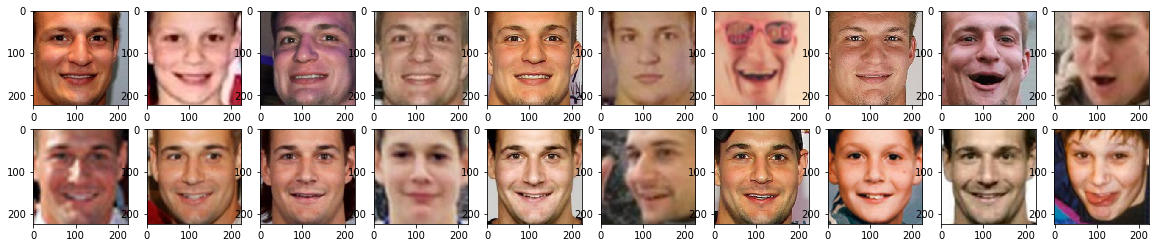

In [6]:
plot_faces(6)

## Create Siamese Neural Network

In [7]:
def model():
    image_l = tf.keras.layers.Input((64, 64, 3))
    image_r = tf.keras.layers.Input((64, 64, 3))
    
    conv_net = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(8, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Conv2D(16, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='sigmoid')
    ])
    
    encoder_l = conv_net(image_l)
    encoder_r = conv_net(image_r)
    
    l1_layer = tf.keras.layers.Lambda(lambda x: tf.abs(x[0] - x[1]))
    l1_distance = l1_layer([encoder_l, encoder_r])
    
    prediction = tf.keras.layers.Dense(1, activation='sigmoid')(l1_distance)
    
    model = tf.keras.models.Model(inputs=[image_l, image_r], outputs=prediction)
    
    return model

Initialize model

In [8]:
siamese_net = model()
siamese_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          57424       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128)          0           sequential[0][0]             

Set optimizer and compile model

In [9]:
optimizer = tf.keras.optimizers.Adam(lr = 0.00006)
siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

## Prepare data loader

Create DataGenerator 

In [97]:
class SiameseDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, pairs, batch_size=32, shuffle=True):
        self.pairs = pairs
        self.batch_size = batch_size
        self.indexes = list(range(len(pairs)))        
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.pairs)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        pair = itemgetter(self.pairs, indexes)
        x, y = self.__generate(pair[0]), pair[1]
        
        return x, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __generate(paths):
        image1 = self.__preprocess_image(imageio.imread(paths[0]))
        image2 = self.__preprocess_image(imageio.imread(paths[1]))
        
        return image1, image2
        
    def __preprocess_image(image):
        image = tf.image.resize(image, (64, 64), preserve_aspect_ratio=True)

        return image

In [91]:
def get_person_family(x):
    tmp = x.replace('dataset/train/', '').split('/')
    return tmp[0], tmp[1]

def create_pairs(files):
    result = []
    
    for img in files:
        x = img.replace('dataset/train/', '').split('/')
        family, person = x[0], x[1]
        family_members = list(filter(lambda x: (family in x) and (person not in x), files))
        
        if len(family_members) == 0:
            continue
        
        other_family_member = np.random.choice(family_members, 1, replace=True)[0]
        
        not_family_members = list(filter(lambda x: family not in x, files))
        
        if len(not_family_members) == 0:
            continue
        
        not_family_member = np.random.choice(not_family_members, 1, replace=True)[0]
        
        result.append(((img, other_family_member), 1))
        result.append(((img, not_family_member), -1))
        
    return result

In [92]:
pattern = 'dataset/train/**/*.jpg'
files = sorted(glob.glob(pattern, recursive=True))
pairs = create_pairs(files)

In [ ]:
siamese_net.fit_generator(SiameseDataGenerator(pairs, batch_size=32), steps_per_epoch=5, epochs=3, verbose=1)